In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import jit, grad, jacfwd, jacrev

In [2]:
def pendulum_dynamics_wo_control(x):

    g = 9.81
    l = 1
    
    q = x[0]
    q_d = x[1]
    q_dd = -(g/l) * np.sin(q)

    return np.array([q_d, q_dd])

@jit
def _pendu_jit(x):

    g = 9.81
    l = 1
    
    q    = x[0]
    q_d  = x[1]
    q_dd = -g/l * jnp.sin(q)

    return jnp.array([q_d, q_dd])

## Method1. Fixed Point Iteration

In [14]:
def backward_euler_step_fixed_point(dynamics_func, x0, h):

    xn = x0
    e = [ np.linalg.norm(x0 + h * dynamics_func(xn) - xn) ]

    while e[-1] > 1e-8:
        xn = x0 + h * dynamics_func(xn)
        e.append(np.linalg.norm(x0 + h * dynamics_func(xn) - xn))
    return xn, e

In [4]:
x0 = [0.1, 0.0]
backward_euler_step_fixed_point(pendulum_dynamics_wo_control, x0, 0.1)

(array([ 0.09107764, -0.08922369]),
 [0.09793658173053843,
  0.009793658173053846,
  0.009564124766684667,
  0.0009564124766684723,
  0.0009343853483241293,
  9.343853483241571e-05,
  9.128296581455142e-05,
  9.128296581450979e-06,
  8.917746787032166e-06,
  8.917746786990532e-07,
  8.712050176828967e-07,
  8.712050177106523e-08,
  8.511098474606182e-08,
  8.511098478769519e-09])

## Method2. Newton's method

In [5]:
@jit
def backward_residual(x, x0, h):
    return x0 + h * _pendu_jit(x) - x

In [12]:
def backward_euler_step_newton(dynamics_func, x0, h):

    xn = x0
    r = x0 + h * np.array(dynamics_func(xn)) - xn
    e = [ np.linalg.norm(r) ]

    while e[-1] > 1e-8:
        jacobian, _, _ = jacrev(backward_residual, argnums=(0,1,2))(xn, x0, h)
        xn = xn - np.linalg.inv(np.array(jacobian)) @ r
        r = x0 + h * np.array(dynamics_func(xn)) - xn
        e.append(np.linalg.norm(r))

    return xn, e

In [13]:
x0 = jnp.array([0.1, 0.0])
backward_euler_step_newton(_pendu_jit, x0, 0.1)

(Array([ 0.09107763, -0.08922369], dtype=float32),
 [0.09793659, 3.784895e-06, 0.0])

## Forward Simulation Comparison

In [15]:
def backward_euler_fixed_point(dynamics_func, x0, Tf, h):

    t = np.arange(0, Tf, h)

    x_hist = np.zeros((len(t), len(x0)))
    x_hist[0] = x0

    for i in range(1, len(t)):
        x_hist[i], e = backward_euler_step_fixed_point(dynamics_func, x_hist[i-1], h)
    
    return x_hist, t

In [19]:
def backward_euler_newton(dynamics_func, x0, Tf, h):
    
    t = np.arange(0, Tf, h)

    x_hist = np.zeros((len(t), len(x0)))
    x_hist[0] = np.array(x0)

    for i in range(1, len(t)):
        x_result, e = backward_euler_step_newton(dynamics_func, jnp.array(x_hist[i-1]), h)
        x_hist[i] = jnp.array(x_result)

    return x_hist, t

In [27]:
x0 = [.1, 0]
x0_jnp = jnp.array(x0)
x_hist1, t_hist1 = backward_euler_fixed_point(pendulum_dynamics_wo_control, x0, 100, 0.01)
x_hist2, t_hist2 = backward_euler_newton(pendulum_dynamics_wo_control, x0_jnp, 100, 0.01)

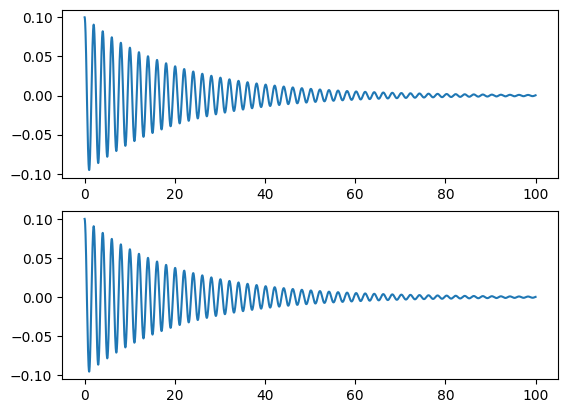

In [28]:
plt.subplot(2,1,1)
plt.plot(t_hist1, x_hist1[:,0])

plt.subplot(2,1,2)
plt.plot(t_hist2, x_hist2[:,0])

In [34]:
np.max(abs(x_hist1 - x_hist2))

1.142127581244684e-05

In [37]:
x0 = [.1, 0]
backward_euler_step_fixed_point(pendulum_dynamics_wo_control, x0, 0.1)

(array([ 0.09107764, -0.08922369]),
 [0.09793658173053843,
  0.009793658173053846,
  0.009564124766684667,
  0.0009564124766684723,
  0.0009343853483241293,
  9.343853483241571e-05,
  9.128296581455142e-05,
  9.128296581450979e-06,
  8.917746787032166e-06,
  8.917746786990532e-07,
  8.712050176828967e-07,
  8.712050177106523e-08,
  8.511098474606182e-08,
  8.511098478769519e-09])

In [38]:
x0_jnp = jnp.array([.1, 0])
backward_euler_step_newton(pendulum_dynamics_wo_control, x0_jnp, 0.1)

(Array([ 0.09107763, -0.08922368], dtype=float32),
 [0.097936586, 3.784895e-06, 7.450581e-09])

## Log-Log Plot

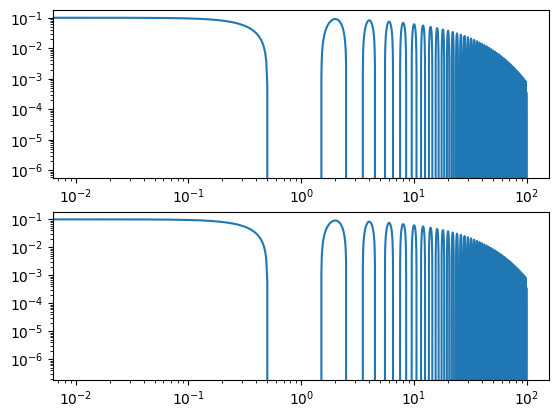

In [39]:
plt.subplot(2,1,1)
plt.yscale('log')
plt.xscale('log')
plt.plot(t_hist1, x_hist1[:,0])

plt.subplot(2,1,2)
plt.yscale('log')
plt.xscale('log')
plt.plot(t_hist2, x_hist2[:,0])